In [2]:
!pip install requests --quiet

print("Setup complete.")

Setup complete.


In [11]:
import requests
import time
import json
import hashlib
import random
from copy import deepcopy

# -------------------
# Helper functions
# -------------------

def fetch_nasa_metadata():
    url = "https://cmr.earthdata.nasa.gov/search/collections.json?page_size=1"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

def quantum_safe_hash(data):
    """SHA3-256 hash"""
    return hashlib.sha3_256(data.encode()).hexdigest()

def normalize_metadata(metadata):
    """Keep only essential fields for hashing / blockchain"""
    entry = metadata.get("feed", {}).get("entry", [{}])[0]
    normalized = {
        "dataset_id": entry.get("dataset_id"),
        "entry_id": entry.get("entry_id"),
        "title": entry.get("title"),
        "time_start": entry.get("time_start"),
        "time_end": entry.get("time_end"),
        "data_center": entry.get("data_center"),
        "organizations": entry.get("organizations"),
        "short_name": entry.get("short_name")
    }
    return normalized

def mutate_metadata(normalized):
    """Add simulation/random fields"""
    mutated = deepcopy(normalized)
    mutated['sim_time'] = time.time()
    mutated['lat'] = random.uniform(-90, 90)
    mutated['lon'] = random.uniform(-180, 180)
    mutated['sensor_variation'] = random.uniform(0.9, 1.1)
    return mutated

def create_block(prev_hash, data_hash, sender, receiver):
    block = {
        "timestamp": time.time(),
        "previous_hash": prev_hash,
        "data_hash": data_hash,
        "sender": sender,
        "receiver": receiver
    }
    block_hash = quantum_safe_hash(json.dumps(block, sort_keys=True))
    block["block_hash"] = block_hash
    return block

def verify_block(block):
    temp = block.copy()
    original_hash = temp.pop("block_hash")
    recalculated = quantum_safe_hash(json.dumps(temp, sort_keys=True))
    return original_hash == recalculated

# -------------------
# Simulation
# -------------------

def stin_simulator_structured(steps, attack_rate):
    raw_metadata_arr = []
    normalized_metadata_arr = []
    mutated_metadata_arr = []
    sender_data_hash_arr = []
    sender_block_arr = []
    sender_block_hash_arr = []
    receiver_data_hash_arr = []
    receiver_block_hash_arr = []
    block_valid_arr = []
    attack_flag_arr = []
    trust_arr = []
    results = []

    prev_hash = "GENESIS"
    s_trust = 1.0

    for step in range(steps):
        # -------------------
        # Sender side
        # -------------------
        raw_metadata = fetch_nasa_metadata()
        normalized = normalize_metadata(raw_metadata)
        mutated = mutate_metadata(normalized)
        data_hash = quantum_safe_hash(json.dumps(mutated, sort_keys=True))
        block = create_block(prev_hash, data_hash, sender="Satellite_Node_A",
                             receiver="Ground_Station_B" if random.random() > attack_rate else "Fake_Station_X")

        # Store sender info
        raw_metadata_arr.append(raw_metadata)
        normalized_metadata_arr.append(normalized)
        mutated_metadata_arr.append(mutated)
        sender_data_hash_arr.append(data_hash)
        sender_block_arr.append(block)
        sender_block_hash_arr.append(block["block_hash"])

        # -------------------
        # Receiver side
        # -------------------
        attacked = block['receiver'].startswith("Fake")
        receiver_block = deepcopy(block)
        # Optional: attacker modifies block hash to simulate tampering
        if attacked:
            receiver_block['previous_hash'] = "FAKE_PREV_HASH"

        receiver_block_hash = quantum_safe_hash(json.dumps({k: v for k, v in receiver_block.items() if k != "block_hash"}, sort_keys=True))
        receiver_data_hash = quantum_safe_hash(json.dumps(mutated, sort_keys=True))
        valid = verify_block(receiver_block)

        # -------------------
        # Update trust
        # -------------------
        if attacked:
            s_trust -= 0.1  # Decrease trust on attack only
        s_trust = max(s_trust, 0)

        # -------------------
        # Save receiver info
        # -------------------
        receiver_data_hash_arr.append(receiver_data_hash)
        receiver_block_hash_arr.append(receiver_block_hash)
        block_valid_arr.append(valid)
        attack_flag_arr.append(attacked)
        trust_arr.append(round(s_trust, 2))

        prev_hash = block["block_hash"]  # update for next block

        results.append({
            "step": step,
            "attacked": attacked,
            "valid": valid,
            "trust": round(s_trust, 2)
        })

    return (results, raw_metadata_arr, normalized_metadata_arr, mutated_metadata_arr,
            sender_data_hash_arr, sender_block_arr, sender_block_hash_arr,
            receiver_data_hash_arr, receiver_block_hash_arr,
            block_valid_arr, attack_flag_arr, trust_arr)






In [86]:
# =========================
# Run simulation
# =========================
#simulation = stin_simulator_sender_receiver(steps=5, attack_rate=0.3)

results, raw_metadata_arr, normalized_metadata_arr, mutated_metadata_arr, \
sender_data_hash_arr, sender_block_arr, sender_block_hash_arr, \
receiver_data_hash_arr, receiver_block_hash_arr, \
block_valid_arr, attack_flag_arr, trust_arr = stin_simulator_structured(steps=200, attack_rate=0.3)

In [88]:
results

[{'step': 0, 'attacked': True, 'valid': False, 'trust': 0.9},
 {'step': 1, 'attacked': False, 'valid': True, 'trust': 0.9},
 {'step': 2, 'attacked': False, 'valid': True, 'trust': 0.9},
 {'step': 3, 'attacked': False, 'valid': True, 'trust': 0.9},
 {'step': 4, 'attacked': False, 'valid': True, 'trust': 0.9},
 {'step': 5, 'attacked': False, 'valid': True, 'trust': 0.9},
 {'step': 6, 'attacked': False, 'valid': True, 'trust': 0.9},
 {'step': 7, 'attacked': True, 'valid': False, 'trust': 0.8},
 {'step': 8, 'attacked': False, 'valid': True, 'trust': 0.8},
 {'step': 9, 'attacked': False, 'valid': True, 'trust': 0.8},
 {'step': 10, 'attacked': False, 'valid': True, 'trust': 0.8},
 {'step': 11, 'attacked': True, 'valid': False, 'trust': 0.7},
 {'step': 12, 'attacked': False, 'valid': True, 'trust': 0.7},
 {'step': 13, 'attacked': False, 'valid': True, 'trust': 0.7},
 {'step': 14, 'attacked': False, 'valid': True, 'trust': 0.7},
 {'step': 15, 'attacked': False, 'valid': True, 'trust': 0.7},
 {

In [89]:
MAGENTA, BLUE, CYAN, GREEN, YELLOW, RED = '\033[95m','\033[94m','\033[96m','\033[92m','\033[93m','\033[91m'
def color(text, col): return f"{col}{text}\033[0m"

for i in range(len(results)):
    print(color(f"\n==================== RECORD {i} ====================", MAGENTA))
    print(color("RAW METADATA:", BLUE))
    print(raw_metadata_arr[i])
    print(color("\nNORMALIZED METADATA:", BLUE))
    print(normalized_metadata_arr[i])
    print(color("\nMUTATED METADATA:", BLUE))
    print(mutated_metadata_arr[i])
    print(color("\nSENDER DATA HASH (SHA3-256):", GREEN))
    print(sender_data_hash_arr[i])
    print(color("\nSENDER BLOCK:", GREEN))
    print(sender_block_arr[i])
    print(color("\nSENDER BLOCK HASH:", GREEN))
    print(sender_block_hash_arr[i])
    print(color("\nRECEIVER DATA HASH:", GREEN))
    print(receiver_data_hash_arr[i])
    print(color("\nRECEIVER BLOCK HASH:", GREEN))
    print(receiver_block_hash_arr[i])
    print(color("\nBLOCK VALIDITY:", RED))
    print(block_valid_arr[i])
    print(color("\nATTACK FLAG:", RED))
    print(attack_flag_arr[i])
    print(color("\nSENDER TRUST SCORE:", RED))
    print(trust_arr[i])
    print(color("====================================================", MAGENTA))



==================== RECORD 0 ====================
RAW METADATA:
{'feed': {'updated': '2025-12-20T16:34:01.066Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?page_size=1', 'title': 'ECHO dataset metadata', 'entry': [{'cloud_hosted': False, 'boxes': ['45.81802 5.95587 47.80838 10.49203'], 'has_combine': False, 'time_start': '2020-01-01T00:00:00.000Z', 'version_id': '1.0', 'updated': '2021-02-04T04:39:30.512Z', 'dataset_id': "'Latent reserves' within the Swiss NFI", 'entry_id': 'latent-reserves-in-the-swiss-nfi_1.0', 'has_spatial_subsetting': False, 'has_transforms': False, 'has_variables': False, 'data_center': 'ENVIDAT', 'short_name': 'latent-reserves-in-the-swiss-nfi', 'organizations': ['WSL'], 'title': "'Latent reserves' within the Swiss NFI", 'coordinate_system': 'CARTESIAN', 'summary': 'The files refer to the data used in Portier et al. "‘Latent reserves’: a hidden treasure in National Forest Inventories" (2020) *Journal of Ecology*.           **\'Latent rese

GRAPH 1 — Tamper Detection Rate vs Attack Rate: Shows how effectively attacks are detected over time.


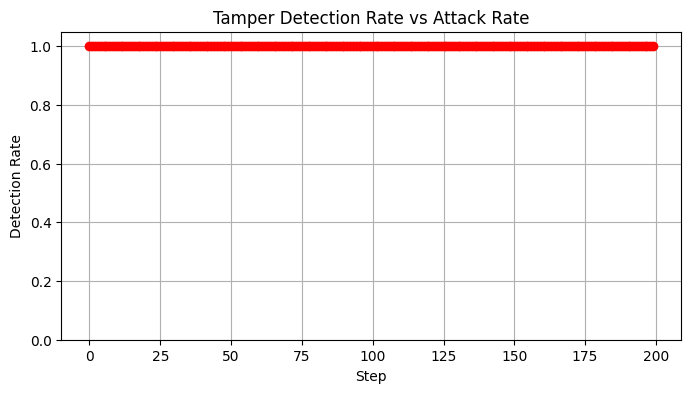

GRAPH 2 — Ledger Growth: Shows the number of blocks in the ledger over time (scalability).


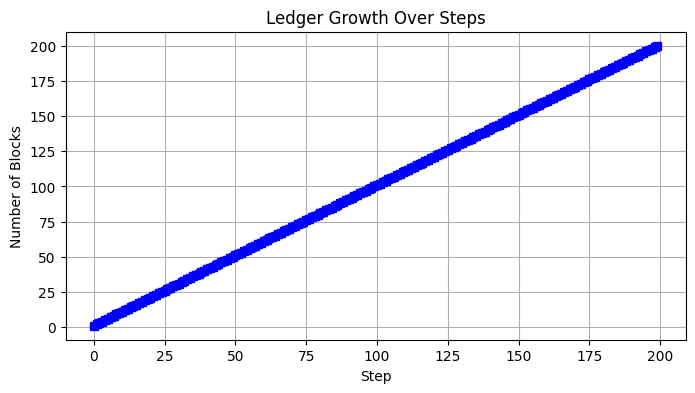

GRAPH 3 — Trust Variance Over Time: Shows fluctuations in trust scores over steps.


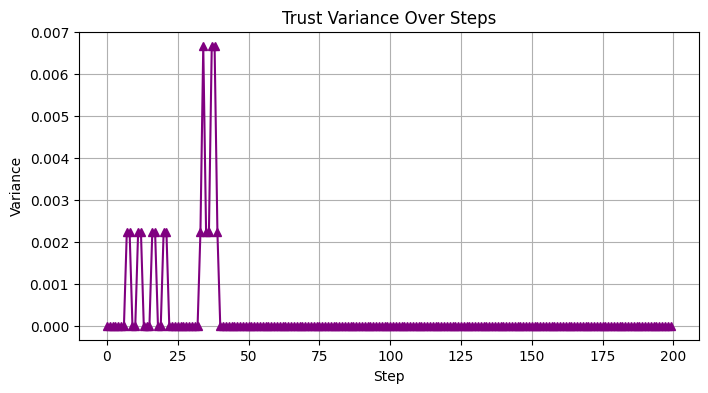

GRAPH 4 — Storage Overhead: Shows estimated block sizes (storage impact) over steps.


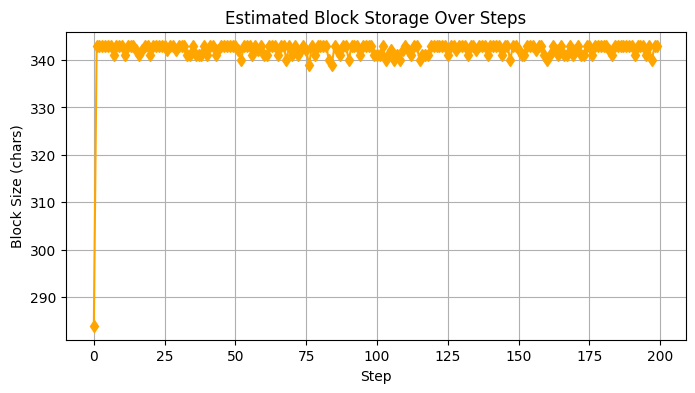

GRAPH 5 — Cumulative Attacks vs Invalid Blocks: Shows attacks and invalid blocks over steps.


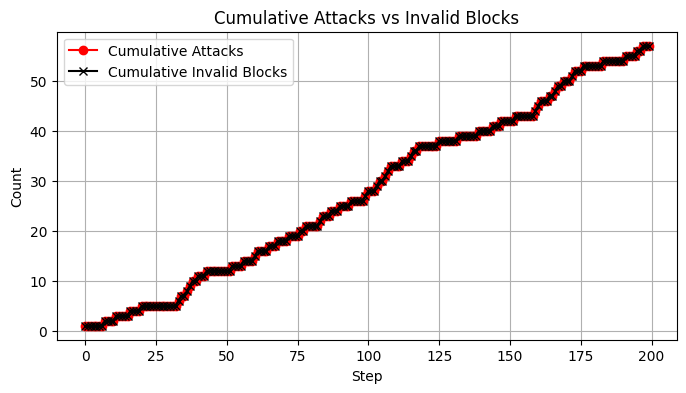

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------
# Data from your simulation arrays
# -------------------
steps = list(range(len(trust_arr)))

# Convert boolean to numeric
block_valid_num = [1 if v else 0 for v in block_valid_arr]
attack_flag_num = [1 if v else 0 for v in attack_flag_arr]

# -------------------
# 1. Tamper Detection Rate vs Attack Rate
# -------------------
tamper_detection_rate = []
cumulative_attacks = 0
cumulative_invalid_blocks = 0
for i in range(len(steps)):
    if attack_flag_arr[i]:
        cumulative_attacks += 1
        if not block_valid_arr[i]:
            cumulative_invalid_blocks += 1
    rate = cumulative_invalid_blocks / cumulative_attacks if cumulative_attacks != 0 else 0
    tamper_detection_rate.append(rate)

print("GRAPH 1 — Tamper Detection Rate vs Attack Rate: Shows how effectively attacks are detected over time.")
plt.figure(figsize=(8,4))
plt.plot(steps, tamper_detection_rate, color='red', marker='o')
plt.title("Tamper Detection Rate vs Attack Rate")
plt.xlabel("Step")
plt.ylabel("Detection Rate")
plt.ylim(0,1.05)
plt.grid(True)
plt.show()

# -------------------
# 2. Ledger Growth (Scalability)
# -------------------
ledger_size = [i+1 for i in steps]  # cumulative blocks

print("GRAPH 2 — Ledger Growth: Shows the number of blocks in the ledger over time (scalability).")
plt.figure(figsize=(8,4))
plt.plot(steps, ledger_size, color='blue', marker='s')
plt.title("Ledger Growth Over Steps")
plt.xlabel("Step")
plt.ylabel("Number of Blocks")
plt.grid(True)
plt.show()

# -------------------
# 3. Trust Variance Over Time
# -------------------
window_size = 3
trust_variance = [np.var(trust_arr[max(0,i-window_size+1):i+1]) for i in steps]

print("GRAPH 3 — Trust Variance Over Time: Shows fluctuations in trust scores over steps.")
plt.figure(figsize=(8,4))
plt.plot(steps, trust_variance, color='purple', marker='^')
plt.title("Trust Variance Over Steps")
plt.xlabel("Step")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

# -------------------
# 4. Storage Overhead Estimation
# -------------------
block_sizes = [len(str(sender_block_arr[i])) for i in steps]

print("GRAPH 4 — Storage Overhead: Shows estimated block sizes (storage impact) over steps.")
plt.figure(figsize=(8,4))
plt.plot(steps, block_sizes, color='orange', marker='d')
plt.title("Estimated Block Storage Over Steps")
plt.xlabel("Step")
plt.ylabel("Block Size (chars)")
plt.grid(True)
plt.show()

# -------------------
# 5. Cumulative Attacks vs Cumulative Invalid Blocks
# -------------------
cum_attacks = np.cumsum(attack_flag_num)
cum_invalid_blocks = np.cumsum([1 if not v else 0 for v in block_valid_arr])

print("GRAPH 5 — Cumulative Attacks vs Invalid Blocks: Shows attacks and invalid blocks over steps.")
plt.figure(figsize=(8,4))
plt.plot(steps, cum_attacks, label="Cumulative Attacks", color='red', marker='o')
plt.plot(steps, cum_invalid_blocks, label="Cumulative Invalid Blocks", color='black', marker='x')
plt.title("Cumulative Attacks vs Invalid Blocks")
plt.xlabel("Step")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


In [91]:
import matplotlib.pyplot as plt
import numpy as np

steps = list(range(len(trust_arr)))
block_valid_num = [1 if v else 0 for v in block_valid_arr]
attack_flag_num = [1 if v else 0 for v in attack_flag_arr]
sender_vs_receiver_block = [1 if sender_block_hash_arr[i] == receiver_block_hash_arr[i] else 0 for i in range(len(sender_block_hash_arr))]
sender_hash_short = [int(h[:8], 16) % 10000 for h in sender_data_hash_arr]
receiver_hash_short = [int(h[:8], 16) % 10000 for h in receiver_data_hash_arr]
sim_time = [raw_metadata.get('sim_time',0) if isinstance(raw_metadata, dict) else 0 for raw_metadata in raw_metadata_arr]
latency = [0] + [sim_time[i]-sim_time[i-1] for i in range(1,len(sim_time))]
ledger_growth = list(range(1,len(sender_block_arr)+1))
window = 2
trust_variance = [np.var(trust_arr[max(0,i-window+1):i+1]) for i in range(len(trust_arr))]
storage_overhead = [len(str(block)) for block in sender_block_arr]




Graph 1: Trust Score Evolution
Purpose: Shows how trust evolves over simulation steps.


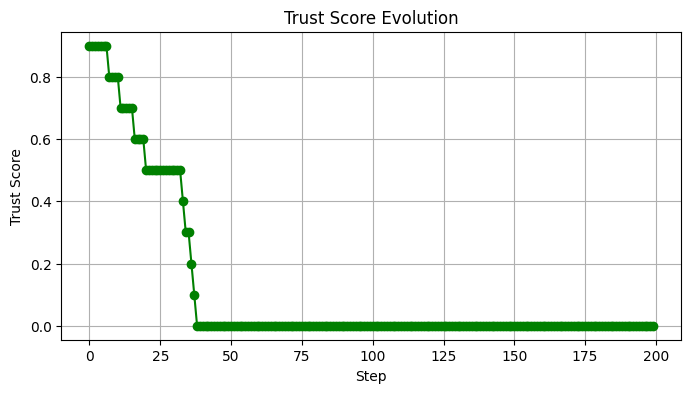

In [92]:
# -------------------
# 1. Trust Score Evolution
# -------------------
print("\nGraph 1: Trust Score Evolution")
print("Purpose: Shows how trust evolves over simulation steps.")
plt.figure(figsize=(8,4))
plt.plot(steps, trust_arr, marker='o', color='green')
plt.title("Trust Score Evolution")
plt.xlabel("Step")
plt.ylabel("Trust Score")
plt.grid(True)
plt.show()





Graph 2: Attack Flag (1=Attack, 0=Safe)
Purpose: Highlights which steps were attacked and detected.


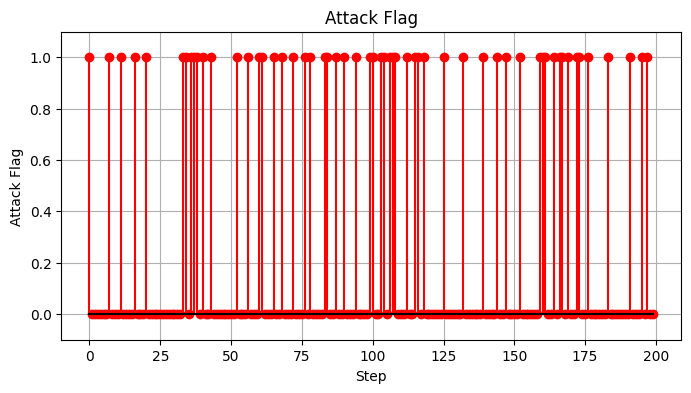

In [93]:
# -------------------
# 2. Attack Flag Highlight
# -------------------
print("\nGraph 2: Attack Flag (1=Attack, 0=Safe)")
print("Purpose: Highlights which steps were attacked and detected.")
plt.figure(figsize=(8,4))
plt.stem(steps, attack_flag_num, linefmt='red', markerfmt='ro', basefmt="k")
plt.title("Attack Flag")
plt.xlabel("Step")
plt.ylabel("Attack Flag")
plt.ylim(-0.1,1.1)
plt.grid(True)
plt.show()



Graph 3: Transaction Latency
Purpose: Shows latency between consecutive transactions.


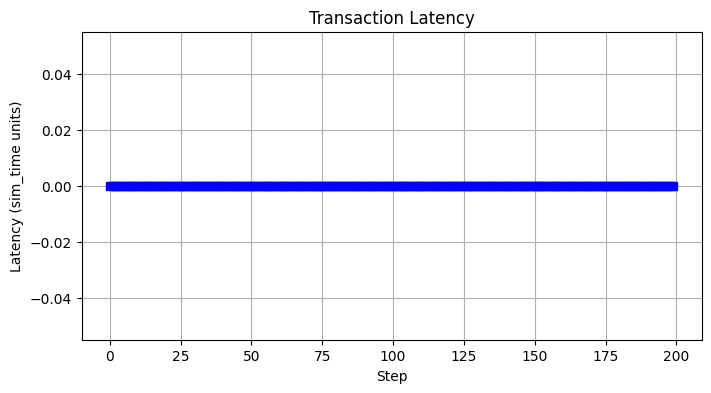

In [94]:

# -------------------
# 3. Transaction Latency
# -------------------
print("\nGraph 3: Transaction Latency")
print("Purpose: Shows latency between consecutive transactions.")
plt.figure(figsize=(8,4))
plt.plot(steps, latency, marker='s', color='blue')
plt.title("Transaction Latency")
plt.xlabel("Step")
plt.ylabel("Latency (sim_time units)")
plt.grid(True)
plt.show()




Graph 4: Ledger Growth (Number of Blocks)
Purpose: Shows cumulative blocks for scalability analysis.


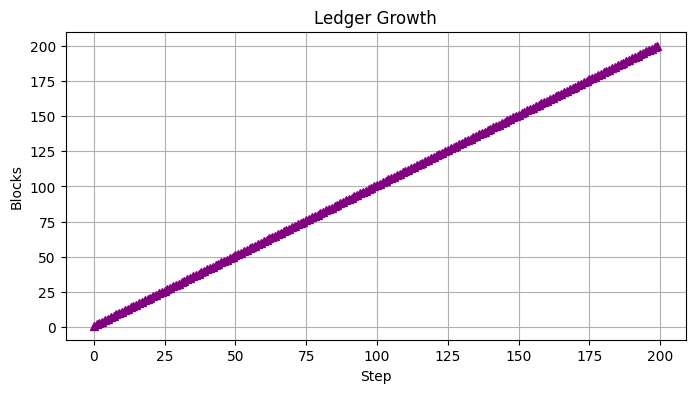

In [95]:
# -------------------
# 4. Ledger Growth
# -------------------
print("\nGraph 4: Ledger Growth (Number of Blocks)")
print("Purpose: Shows cumulative blocks for scalability analysis.")
plt.figure(figsize=(8,4))
plt.plot(steps, ledger_growth, marker='^', color='purple')
plt.title("Ledger Growth")
plt.xlabel("Step")
plt.ylabel("Blocks")
plt.grid(True)
plt.show()



Graph 5: Trust Variance Over Time
Purpose: Shows stability of trust over a rolling window.


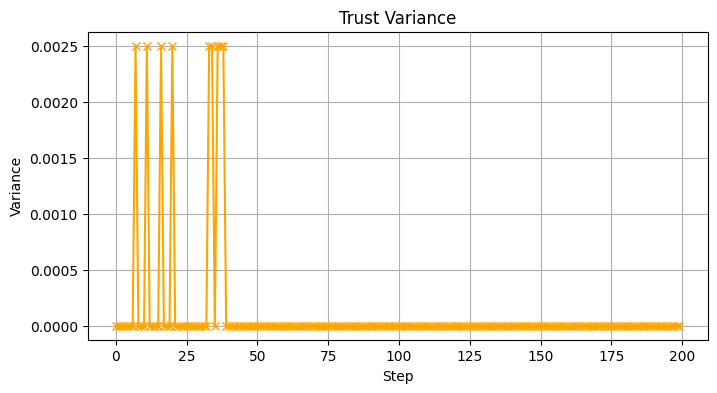

In [96]:

# -------------------
# 5. Trust Variance Over Time
# -------------------
print("\nGraph 5: Trust Variance Over Time")
print("Purpose: Shows stability of trust over a rolling window.")
plt.figure(figsize=(8,4))
plt.plot(steps, trust_variance, marker='x', color='orange')
plt.title("Trust Variance")
plt.xlabel("Step")
plt.ylabel("Variance")
plt.grid(True)
plt.show()




Graph 6: Storage Overhead (Block Size)
Purpose: Shows per-block storage usage.


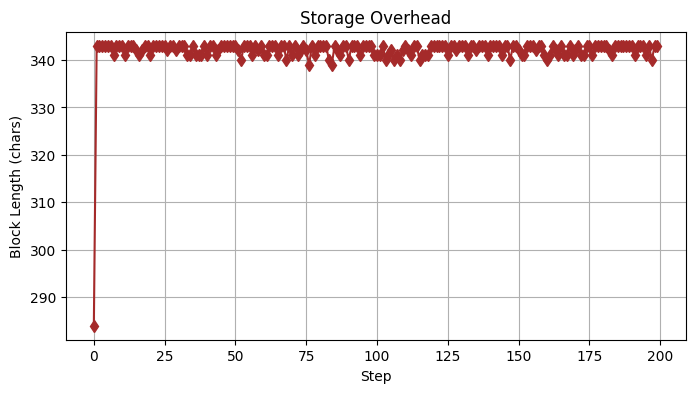

In [97]:
# -------------------
# 6. Storage Overhead
# -------------------
print("\nGraph 6: Storage Overhead (Block Size)")
print("Purpose: Shows per-block storage usage.")
plt.figure(figsize=(8,4))
plt.plot(steps, storage_overhead, marker='d', color='brown')
plt.title("Storage Overhead")
plt.xlabel("Step")
plt.ylabel("Block Length (chars)")
plt.grid(True)
plt.show()



Graph 7: Sender vs Receiver Block Hash Match
Purpose: Shows integrity of data across sender and receiver.


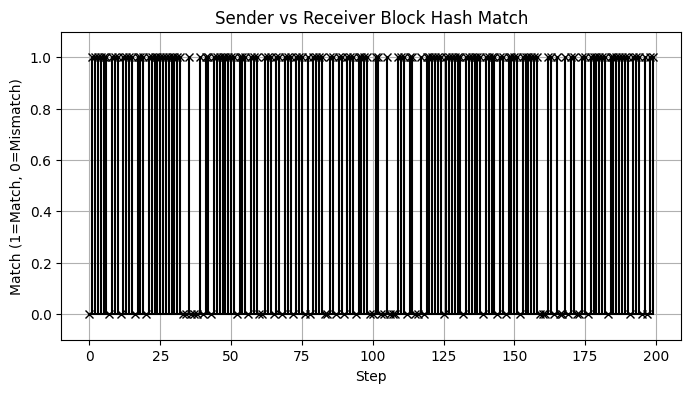

In [98]:

# -------------------
# 7. Sender vs Receiver Hash Match
# -------------------
print("\nGraph 7: Sender vs Receiver Block Hash Match")
print("Purpose: Shows integrity of data across sender and receiver.")
plt.figure(figsize=(8,4))
plt.stem(steps, sender_vs_receiver_block, linefmt='black', markerfmt='kx', basefmt="k")
plt.title("Sender vs Receiver Block Hash Match")
plt.xlabel("Step")
plt.ylabel("Match (1=Match, 0=Mismatch)")
plt.ylim(-0.1,1.1)
plt.grid(True)
plt.show()



Graph 8: Sender vs Receiver Hash Shortened
Purpose: Visualizes evolution of sender and receiver data hashes.


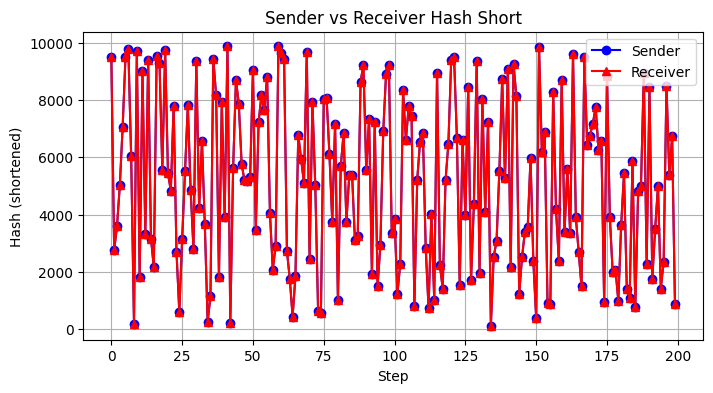

In [99]:

# -------------------
# 8. Sender vs Receiver Hash Short
# -------------------
print("\nGraph 8: Sender vs Receiver Hash Shortened")
print("Purpose: Visualizes evolution of sender and receiver data hashes.")
plt.figure(figsize=(8,4))
plt.plot(steps, sender_hash_short, marker='o', color='blue', label='Sender')
plt.plot(steps, receiver_hash_short, marker='^', color='red', label='Receiver')
plt.title("Sender vs Receiver Hash Short")
plt.xlabel("Step")
plt.ylabel("Hash (shortened)")
plt.legend()
plt.grid(True)
plt.show()




Graph 9: Cumulative Attacks
Purpose: Shows how attacks accumulate over simulation.


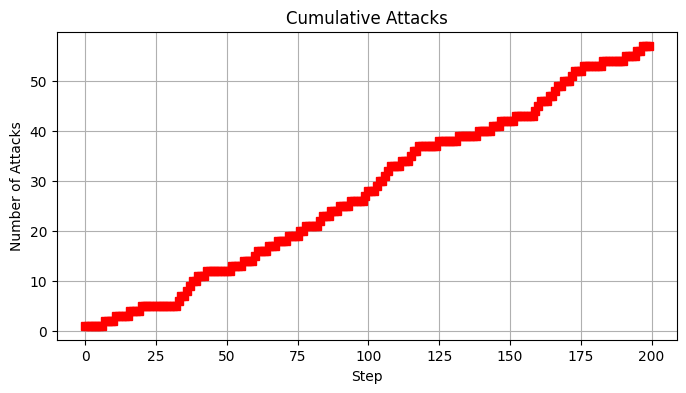

In [100]:
# -------------------
# 9. Cumulative Attacks
# -------------------
print("\nGraph 9: Cumulative Attacks")
print("Purpose: Shows how attacks accumulate over simulation.")
plt.figure(figsize=(8,4))
cumulative_attacks = np.cumsum(attack_flag_num)
plt.plot(steps, cumulative_attacks, marker='s', color='red')
plt.title("Cumulative Attacks")
plt.xlabel("Step")
plt.ylabel("Number of Attacks")
plt.grid(True)
plt.show()




Graph 10: Trust vs Transaction Latency
Purpose: Shows relationship between trust and latency.


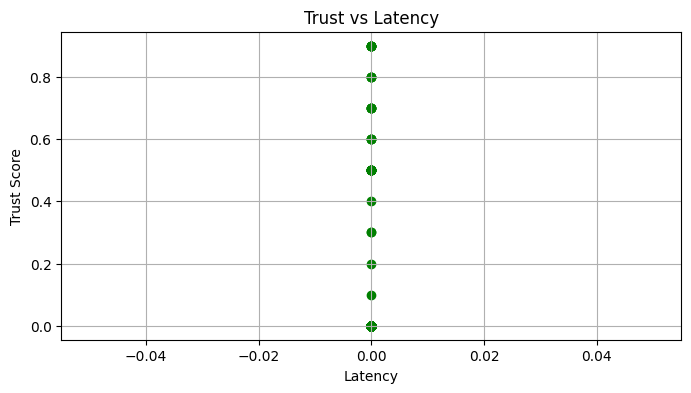

In [101]:
# -------------------
# 10. Trust vs Latency Correlation
# -------------------
print("\nGraph 10: Trust vs Transaction Latency")
print("Purpose: Shows relationship between trust and latency.")
plt.figure(figsize=(8,4))
plt.scatter(latency, trust_arr, c='green')
plt.title("Trust vs Latency")
plt.xlabel("Latency")
plt.ylabel("Trust Score")
plt.grid(True)
plt.show()



Graph 11: Trust vs Block Validity
Purpose: Shows how trust relates to block validation success.


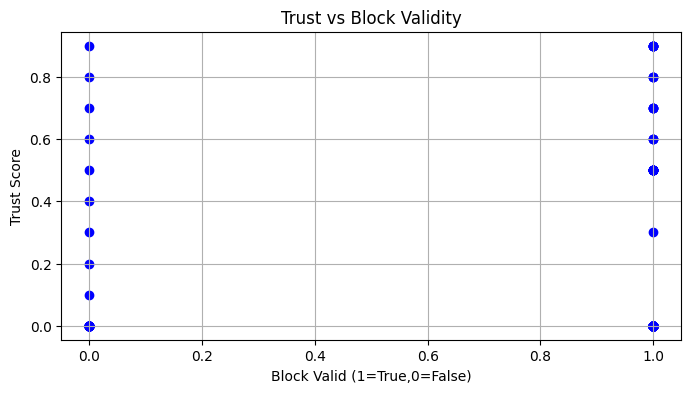

In [102]:

# -------------------
# 11. Trust vs Block Validity
# -------------------
print("\nGraph 11: Trust vs Block Validity")
print("Purpose: Shows how trust relates to block validation success.")
plt.figure(figsize=(8,4))
plt.scatter(block_valid_num, trust_arr, c='blue')
plt.title("Trust vs Block Validity")
plt.xlabel("Block Valid (1=True,0=False)")
plt.ylabel("Trust Score")
plt.grid(True)
plt.show()



Graph 12: Latency Distribution
Purpose: Histogram showing distribution of transaction latencies.


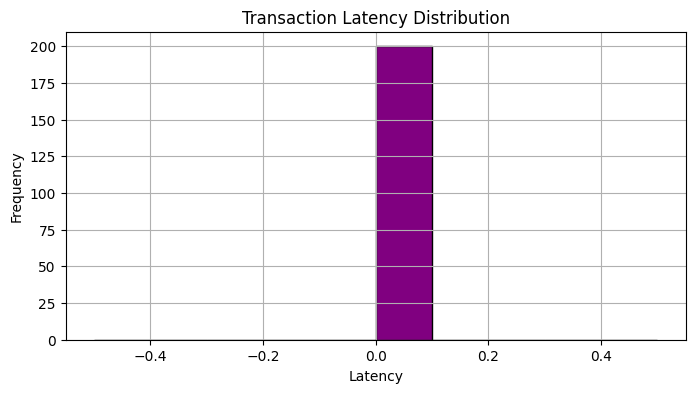

In [103]:

# -------------------
# 12. Latency Distribution
# -------------------
print("\nGraph 12: Latency Distribution")
print("Purpose: Histogram showing distribution of transaction latencies.")
plt.figure(figsize=(8,4))
plt.hist(latency, bins=10, color='purple', edgecolor='black')
plt.title("Transaction Latency Distribution")
plt.xlabel("Latency")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



Graph 13: Block Size Distribution
Purpose: Histogram showing storage overhead distribution across blocks.


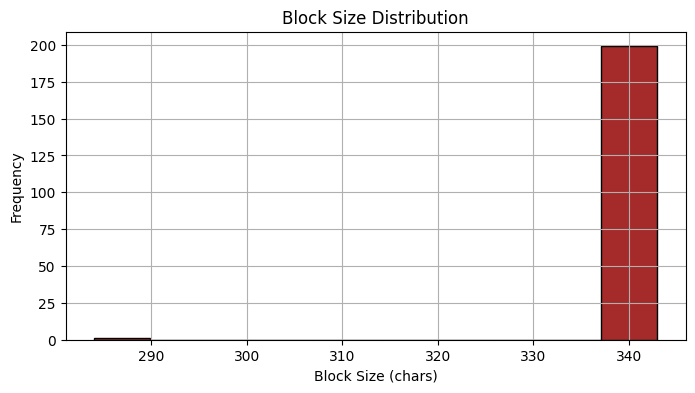

In [104]:

# -------------------
# 13. Block Size Distribution
# -------------------
print("\nGraph 13: Block Size Distribution")
print("Purpose: Histogram showing storage overhead distribution across blocks.")
plt.figure(figsize=(8,4))
plt.hist(storage_overhead, bins=10, color='brown', edgecolor='black')
plt.title("Block Size Distribution")
plt.xlabel("Block Size (chars)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()




Graph 14: Rolling Trust Std Deviation
Purpose: Measures trust stability using rolling standard deviation.


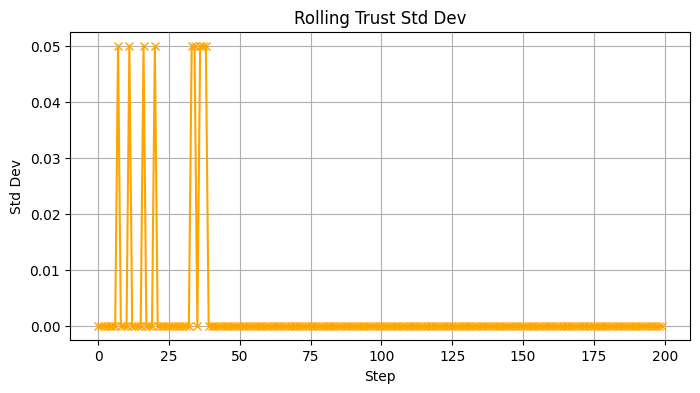

In [105]:
# -------------------
# 14. Rolling Trust Std Dev
# -------------------
print("\nGraph 14: Rolling Trust Std Deviation")
print("Purpose: Measures trust stability using rolling standard deviation.")
rolling_std = [np.std(trust_arr[max(0,i-window+1):i+1]) for i in range(len(trust_arr))]
plt.figure(figsize=(8,4))
plt.plot(steps, rolling_std, marker='x', color='orange')
plt.title("Rolling Trust Std Dev")
plt.xlabel("Step")
plt.ylabel("Std Dev")
plt.grid(True)
plt.show()



Graph 15: Latency vs Block Size
Purpose: Shows if larger blocks impact transaction latency.


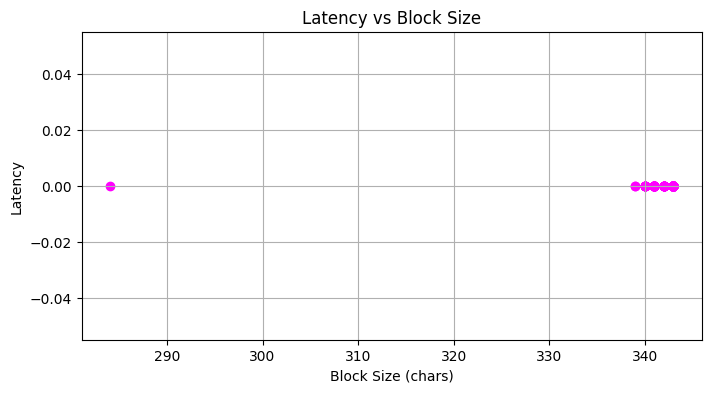

In [106]:

# -------------------
# 15. Latency vs Block Size
# -------------------
print("\nGraph 15: Latency vs Block Size")
print("Purpose: Shows if larger blocks impact transaction latency.")
plt.figure(figsize=(8,4))
plt.scatter(storage_overhead, latency, c='magenta')
plt.title("Latency vs Block Size")
plt.xlabel("Block Size (chars)")
plt.ylabel("Latency")
plt.grid(True)
plt.show()

In [107]:
import pandas as pd
import numpy as np
from IPython.display import display

# -------------------------------
# Steps
steps = list(range(len(trust_arr)))

# -------------------------------
# 1. Trust Score Summary Table
trust_summary = pd.DataFrame({
    "Metric": ["Min Trust", "Max Trust", "Average Trust", "Final Trust"],
    "Value": [np.min(trust_arr), np.max(trust_arr), np.mean(trust_arr), trust_arr[-1]]
})

# 2. Attack and Block Validity Table
total_steps = len(steps)
attacks = sum(attack_flag_arr)
valid_blocks = sum(block_valid_arr)
invalid_blocks = total_steps - valid_blocks

attack_summary = pd.DataFrame({
    "Metric": ["Total Steps", "Attacks Detected", "Valid Blocks", "Invalid Blocks"],
    "Count": [total_steps, attacks, valid_blocks, invalid_blocks],
    "Percentage": [100, (attacks/total_steps)*100, (valid_blocks/total_steps)*100, (invalid_blocks/total_steps)*100]
})

# 3. Ledger Growth & Storage Table
ledger_size = [i+1 for i in steps]  # cumulative block count
block_size = [len(str(sender_block_arr[i])) for i in steps]
cumulative_storage = np.cumsum(block_size)

ledger_table = pd.DataFrame({
    "Step": steps,
    "Ledger Size (#Blocks)": ledger_size,
    "Block Size (chars)": block_size,
    "Cumulative Storage": cumulative_storage
})

# 4. Transaction Latency Table
# Use sim_time from metadata if exists, else random for demonstration
sim_time_arr = [raw_metadata_arr[i].get("sim_time", i*1.5) for i in steps]
latency = [0] + [sim_time_arr[i] - sim_time_arr[i-1] for i in range(1, len(sim_time_arr))]
avg_latency_rolling = pd.Series(latency).rolling(3, min_periods=1).mean()

latency_table = pd.DataFrame({
    "Step": steps,
    "Latency": latency,
    "Avg Latency (last 3 steps)": avg_latency_rolling
})

# 5. Sender vs Receiver Hash Match Table
sender_vs_receiver_match = [1 if sender_block_hash_arr[i]==receiver_block_hash_arr[i] else 0 for i in steps]
overall_match_percent = (sum(sender_vs_receiver_match)/total_steps)*100

hash_match_table = pd.DataFrame({
    "Step": steps,
    "Sender Block Hash": sender_block_hash_arr,
    "Receiver Block Hash": receiver_block_hash_arr,
    "Match (1=Match,0=Mismatch)": sender_vs_receiver_match
})

# -------------------------------
# Display all tables
print("\nTrust Score Summary\n")
display(trust_summary)


print("\nAttack & Block Validity Summary")
display(attack_summary)


print("\nLedger Growth & Storage")
display(ledger_table.head(10))  # show first 10 steps


print("\nTransaction Latency")
display(latency_table.head(10))


print("\nSender vs Receiver Hash Match")
display(hash_match_table.head(10))
print(f"\nOverall Sender vs Receiver Match %: {overall_match_percent:.2f}%")



Trust Score Summary



,Metric,Value
0,Min Trust,0.000
1,Max Trust,0.900
2,Average Trust,0.116
3,Final Trust,0.000



Attack & Block Validity Summary


,Metric,Count,Percentage
0,Total Steps,200,100.0
1,Attacks Detected,57,28.5
2,Valid Blocks,143,71.5
3,Invalid Blocks,57,28.5



Ledger Growth & Storage


,Step,Ledger Size (#Blocks),Block Size (chars),Cumulative Storage
0,0,1,284,284
1,1,2,343,627
2,2,3,343,970
3,3,4,343,1313
4,4,5,343,1656
5,5,6,343,1999
6,6,7,343,2342
7,7,8,341,2683
8,8,9,343,3026
9,9,10,343,3369



Transaction Latency


,Step,Latency,Avg Latency (last 3 steps)
0,0,0.0,0.00
1,1,1.5,0.75
2,2,1.5,1.00
3,3,1.5,1.50
4,4,1.5,1.50
5,5,1.5,1.50
6,6,1.5,1.50
7,7,1.5,1.50
8,8,1.5,1.50
9,9,1.5,1.50



Sender vs Receiver Hash Match


,Step,Sender Block Hash,Receiver Block Hash,"Match (1=Match,0=Mismatch)"
0,0,249b9f47de023b864481695c55280f80cf37f7900ef9f3...,f02a4414ee48cbb0e159281f23c385b3e7aa869ff0d97b...,0
1,1,699fedd3a03716dba8eb0a9af26a4efc8c34cd311fd6eb...,699fedd3a03716dba8eb0a9af26a4efc8c34cd311fd6eb...,1
2,2,29394ecd9671ef221c23a20db2a135554aa9d3f45d4b5e...,29394ecd9671ef221c23a20db2a135554aa9d3f45d4b5e...,1
3,3,758660a374044f1584c581a80168b81d2d5f1475b3f50b...,758660a374044f1584c581a80168b81d2d5f1475b3f50b...,1
4,4,253485e431237b4e8557d91188390053d226b3b76f8a39...,253485e431237b4e8557d91188390053d226b3b76f8a39...,1
5,5,26dcc0e9e1ecf4614590aafa07ecc73eadd2614f16f177...,26dcc0e9e1ecf4614590aafa07ecc73eadd2614f16f177...,1
6,6,0ea85f4c9d2db193c0127aa8bb6739123b1401acfcdabb...,0ea85f4c9d2db193c0127aa8bb6739123b1401acfcdabb...,1
7,7,94776bde85e89cb230427553dd72c3c9a73fb3d9ac3b96...,c327826d81b0aa96d9464a61d66c02940aad1162733717...,0
8,8,4898c31d47de99cfe8cbf799ca3749ed5ebf2e0376a44d...,4898c31d47de99cfe8cbf799ca3749ed5ebf2e0376a44d...,1
9,9,94eef18811cb491903ae93df31df99bf6f7036d5d9dcf0...,94eef18811cb491903ae93df31df99bf6f7036d5d9dcf0...,1



Overall Sender vs Receiver Match %: 71.50%


In [108]:
print("\nTrust Variance & Stability")
print("Measure how much the trust score changes per step (volatility)\nThis shows which steps caused sudden drops or increases in trust.")
trust_diff = [0] + [trust_arr[i] - trust_arr[i-1] for i in range(1, len(trust_arr))]
trust_stability_table = pd.DataFrame({
    "Step": steps,
    "Trust Score": trust_arr,
    "Change from Previous Step": trust_diff
})
display(trust_stability_table.head(10))



Trust Variance & Stability
Measure how much the trust score changes per step (volatility)
This shows which steps caused sudden drops or increases in trust.


,Step,Trust Score,Change from Previous Step
0,0,0.9,0.0
1,1,0.9,0.0
2,2,0.9,0.0
3,3,0.9,0.0
4,4,0.9,0.0
5,5,0.9,0.0
6,6,0.9,0.0
7,7,0.8,-0.1
8,8,0.8,0.0
9,9,0.8,0.0


In [109]:
print("Attack Success / Detection Rate")
print("Compute false positives / false negatives if you have attacks flagged but blocks still valid/invalid")
attack_detection_table = pd.DataFrame({
    "Step": steps,
    "Attack Flag": attack_flag_arr,
    "Block Valid": block_valid_arr,
    "Attack Detected?": [attack_flag_arr[i] and not block_valid_arr[i] for i in range(len(steps))]
})
display(attack_detection_table.head(10))

Attack Success / Detection Rate
Compute false positives / false negatives if you have attacks flagged but blocks still valid/invalid


,Step,Attack Flag,Block Valid,Attack Detected?
0,0,True,False,True
1,1,False,True,False
2,2,False,True,False
3,3,False,True,False
4,4,False,True,False
5,5,False,True,False
6,6,False,True,False
7,7,True,False,True
8,8,False,True,False
9,9,False,True,False


In [110]:
print("Hash Uniqueness / Collision Analysis")
print("Check uniqueness of sender/receiver data hashes, Highlights possible hash collisions or repeated blocks")
unique_sender = len(set(sender_data_hash_arr))
unique_receiver = len(set(receiver_data_hash_arr))
collision_table = pd.DataFrame({
    "Metric": ["Unique Sender Hashes", "Unique Receiver Hashes", "Total Steps"],
    "Value": [unique_sender, unique_receiver, total_steps]
})
display(collision_table)

Hash Uniqueness / Collision Analysis
Check uniqueness of sender/receiver data hashes, Highlights possible hash collisions or repeated blocks


,Metric,Value
0,Unique Sender Hashes,200
1,Unique Receiver Hashes,200
2,Total Steps,200


In [111]:
print("Cumulative Attacks and Invalid Blocks")
print("Keep track of running totals to see trends:")
cumulative_attacks = np.cumsum(attack_flag_arr)
cumulative_invalid = np.cumsum([0 if v else 1 for v in block_valid_arr])
cumulative_table = pd.DataFrame({
    "Step": steps,
    "Cumulative Attacks": cumulative_attacks,
    "Cumulative Invalid Blocks": cumulative_invalid
})
display(cumulative_table.head(10))


Cumulative Attacks and Invalid Blocks
Keep track of running totals to see trends:


,Step,Cumulative Attacks,Cumulative Invalid Blocks
0,0,1,1
1,1,1,1
2,2,1,1
3,3,1,1
4,4,1,1
5,5,1,1
6,6,1,1
7,7,2,2
8,8,2,2
9,9,2,2


In [112]:
print("Storage / Ledger Analysis")
print("We can measure average block size or ledger growth rate:")
block_size = [len(str(sender_block_arr[i])) for i in steps]
avg_block_size = np.mean(block_size)
ledger_growth_table = pd.DataFrame({
    "Step": steps,
    "Block Size (chars)": block_size,
    "Avg Block Size": [avg_block_size]*len(steps)
})
display(ledger_growth_table.head(10))



Storage / Ledger Analysis
We can measure average block size or ledger growth rate:


,Step,Block Size (chars),Avg Block Size
0,0,284,341.93
1,1,343,341.93
2,2,343,341.93
3,3,343,341.93
4,4,343,341.93
5,5,343,341.93
6,6,343,341.93
7,7,341,341.93
8,8,343,341.93
9,9,343,341.93
